In [2]:
%cd 50.039-Deep-Learning-Project-Tonality-Recognition/train/

/home/jovyan/DL/50.039-Deep-Learning-Project-Tonality-Recognition/train


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import sys
from os.path import dirname, abspath
sys.path.append("/home/jovyan/DL/50.039-Deep-Learning-Project-Tonality-Recognition/")

import Constants
from TrainHelpers import mfcc_model_training_phase, mfcc_model_testing_phase, gen_confusion_matrix, data_prep
from models.LSTMModel import LSTM
from Dataset import TessDataset

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train, x_val, x_test, y_train, y_val, y_test = data_prep("../data")

100%|██████████| 2800/2800 [02:46<00:00, 16.86it/s]

Classes are  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'ps': 5, 'sad': 6}



/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
train_loader = DataLoader(TessDataset(x_train, y_train), batch_size=Constants.LSTM_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TessDataset(x_test, y_test), batch_size=Constants.LSTM_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TessDataset(x_val, y_val), batch_size=Constants.LSTM_BATCH_SIZE, shuffle=True)

In [6]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob=0.2):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(device)
        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [7]:
model = RNNModel(Constants.LSTM_INPUT_SIZE, Constants.LSTM_HIDDEN_SIZE, Constants.LSTM_LAYER_SIZE, Constants.LSTM_OUTPUT_SIZE)

In [8]:
model.to(device)

RNNModel(
  (rnn): RNN(40, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=7, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
tb = SummaryWriter()

In [10]:
epochs = 20
patience = 10
batch_size = 10
mfcc_model_training_phase(model, train_loader, val_loader, optimizer, criterion, tb, epochs, patience, batch_size, False)

Training started...
TRAIN | Epoch: 1/20 | Loss: 0.95 | Accuracy: 0.64
VALIDATION | Epoch: 1/20 | Loss: 0.49 | Accuracy: 0.84
TRAIN | Epoch: 2/20 | Loss: 0.43 | Accuracy: 0.86
VALIDATION | Epoch: 2/20 | Loss: 0.40 | Accuracy: 0.88
TRAIN | Epoch: 3/20 | Loss: 0.26 | Accuracy: 0.91
VALIDATION | Epoch: 3/20 | Loss: 0.26 | Accuracy: 0.92
TRAIN | Epoch: 4/20 | Loss: 0.44 | Accuracy: 0.87
VALIDATION | Epoch: 4/20 | Loss: 0.89 | Accuracy: 0.66
TRAIN | Epoch: 5/20 | Loss: 0.44 | Accuracy: 0.84
VALIDATION | Epoch: 5/20 | Loss: 0.30 | Accuracy: 0.91
TRAIN | Epoch: 6/20 | Loss: 0.21 | Accuracy: 0.93
VALIDATION | Epoch: 6/20 | Loss: 0.15 | Accuracy: 0.95
TRAIN | Epoch: 7/20 | Loss: 0.23 | Accuracy: 0.93
VALIDATION | Epoch: 7/20 | Loss: 0.43 | Accuracy: 0.86
TRAIN | Epoch: 8/20 | Loss: 0.18 | Accuracy: 0.94
VALIDATION | Epoch: 8/20 | Loss: 0.15 | Accuracy: 0.94
TRAIN | Epoch: 9/20 | Loss: 0.14 | Accuracy: 0.95
VALIDATION | Epoch: 9/20 | Loss: 0.13 | Accuracy: 0.96
TRAIN | Epoch: 10/20 | Loss: 0.09 |

In [33]:
mfcc_model_testing_phase(model, test_loader, '', batch_size)

Testing Started...
TEST | Average Accuracy per 28 Loaders: 0.97857


IsADirectoryError: [Errno 21] Is a directory: './'

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def generate_plot(train, val, typ='loss', model='MLP'):
    if len(train) != len(val):
        raise Exception("Input data arrays of different length.")
    
    # params
    nepochs = len(train)
    title_fontsize = '18'
    label_fontsize = '15'
    xtick_fontsize = '14'
    ytick_fontsize = '14'
    
    fig = plt.figure(figsize=(8,6))
    x = np.arange(nepochs)
    
    plt.plot(x, train, label='train')
    plt.plot(x, val, label='val')
    
    if typ == 'loss':
        title = 'Training and Validation Loss'
        ylabel = 'Loss Value'
    elif typ == 'acc':
        title = 'Training and Validation Accuracy'
        ylabel = 'Accuracy'
        
    title = title + ' ' + '(' + model + ')'
        
    xlabel = 'Epochs'
    plt.title(title, fontsize=title_fontsize)
    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    plt.xticks(fontsize=xtick_fontsize)
    plt.yticks(fontsize=ytick_fontsize)
    plt.legend(fontsize=ytick_fontsize, bbox_to_anchor=(1.04,1), loc="upper left")
    plt.tight_layout()
    plt.savefig('books_read.png', dpi=250)
    plt.show()

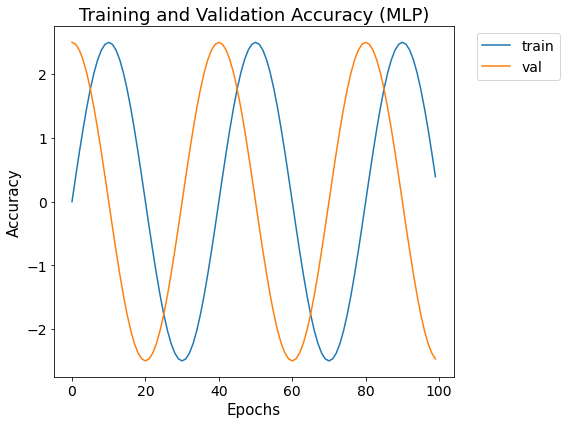

In [55]:
x = np.arange(100)
a = 2.5 * np.sin(x / 20 * np.pi)
b = 2.5 * np.cos(x / 20 * np.pi)

generate_plot(a, b, typ='acc')